In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.width", 1000)

In [3]:
logs = [
    "../log-simple-client1",
    "../log-single-client1",
    "../log-simple-reverse1",
    "../log-single-reverse1",
]


In [4]:
names = {
    "../log-simple-client1-h2": "HTTP/2 /simple.html\n実験1",
    "../log-simple-client1-h3": "HTTP/3 /simple.html\n実験1",
    "../log-single-client1-h2": "HTTP/2 /single.html\n実験1",
    "../log-single-client1-h3": "HTTP/3 /single.html\n実験1",
    "../log-simple-reverse1-h2": "HTTP/2 /simple.html\n実験3",
    "../log-simple-reverse1-h3": "HTTP/3 /simple.html\n実験3",
    "../log-single-reverse1-h2": "HTTP/2 /single.html\n実験3",
    "../log-single-reverse1-h3": "HTTP/3 /single.html\n実験3",
}


In [5]:
def analyze(
    df: pd.DataFrame, log: str, protocol: str
) -> tuple[pd.Series, pd.DataFrame]:
    df = df[
        ((df["protocol"] == "h2") | (df["protocol"] == "h3")) & (df["status"] == 200)
    ]
    # print(f"{df.size=}")

    df_groupby = df[["n", "startMili", "endMili", "baseUnixTime"]].groupby("n")

    # print(f'start = {df_groupby.min()["baseUnixTime"].min()}')
    # print(f'end = {df_groupby.max()["baseUnixTime"].max()}')

    df_groupby_count = df_groupby.count()["startMili"]
    df_success = df_groupby_count == df_groupby_count.mode()[0]
    # print(f"{df_success[df_success].size=}")

    df_mins = df_groupby.min()["startMili"]
    df_maxs = df_groupby.max()["endMili"]
    duration_df = df_maxs - df_mins
    duration_df = duration_df[df_success]

    duration_df_describe = duration_df.describe()
    duration_df_describe["filtered"] = False
    duration_df_describe["Path"] = f"{log}-{protocol}"

    df_lower_limit = duration_df_describe["mean"] - duration_df_describe["std"] * 3
    df_upper_limit = duration_df_describe["mean"] + duration_df_describe["std"] * 3

    duration_df_filtered = duration_df[
        (df_lower_limit < duration_df) & (duration_df < df_upper_limit)
    ]
    duration_df_filtered = duration_df_filtered.reset_index(drop=True)

    df_des = duration_df_filtered.describe()
    df_des["filtered"] = True
    df_des["Path"] = f"{log}-{protocol}"

    return (
        duration_df_filtered,
        pd.DataFrame(
            [duration_df_describe, df_des],
            # index=[f"{log}-{protocol}", f"{log}-{protocol}"],
        ),
    )


In [6]:
def compare(df: pd.DataFrame, descrives: pd.DataFrame, log: str):
    h2 = pd.read_json(log + "/h2-performances-processed.json")
    h3 = pd.read_json(log + "/h3-performances-prosessed.json")
    print(
        h2["baseUnixTime"].max() - h2["baseUnixTime"].min(),
        h3["baseUnixTime"].max() - h3["baseUnixTime"].min(),
    )
    series_h2, result_h2 = analyze(h2, log, "h2")
    descrives = pd.concat([descrives, result_h2])
    series_h3, result_h3 = analyze(h3, log, "h3")
    result = pd.concat([series_h2, series_h3], axis=1)
    result.columns = [f"{log}-h2", f"{log}-h3"]
    df = pd.concat([df, result], axis=1)
    descrives = pd.concat([descrives, result_h3])

    return df, descrives


In [7]:
results = pd.DataFrame()
describes = pd.DataFrame(
    columns=["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
)
for log in logs:
    (results, describes) = compare(results, describes, log)
print(results.count())
results.to_csv("client-time.csv")
describes = describes.sort_values("filtered")
describes["Path"] = describes["Path"].replace(names)
describes = describes.rename(
    columns={
        "Path": "実験",
        "count": "リクエスト数",
        "mean": "平均値",
        "std": "標準偏差",
        "min": "最小値",
        "25%": "第1四分数",
        "50%": "中央値",
        "75%": "第3四分数",
        "max": "最大",
    }
)
describes = describes.reindex(
    columns=[
        "実験",
        "リクエスト数",
        "平均値",
        "標準偏差",
        "最小値",
        "第1四分数",
        "中央値",
        "第3四分数",
        "最大",
        "filtered",
    ]
)
describes.to_csv("client-time-describe.csv")

describe_unfiltered = describes[describes["filtered"] == False].drop(
    columns=["filtered"]
)
describe_unfiltered.to_csv("client-time-describe-unfiltered.csv", index=False)
describe_filtered = describes[describes["filtered"] == True].drop(columns=["filtered"])
describe_filtered.to_csv("client-time-describe-filtered.csv", index=False)


1231523 1233036


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])


2718418 2631477
1232529 1232899


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:14: FutureW

2686880 2623179
../log-simple-client1-h2      996
../log-simple-client1-h3      990
../log-single-client1-h2     1000
../log-single-client1-h3      995
../log-simple-reverse1-h2     998
../log-simple-reverse1-h3     994
../log-single-reverse1-h2     998
../log-single-reverse1-h3     992
dtype: int64


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_80965/4128103056.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])


In [8]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
font = {"family": "YuGothic"}
matplotlib.rc("font", **font)


In [9]:
describe_unfiltered

,実験,リクエスト数,平均値,標準偏差,最小値,第1四分数,中央値,第3四分数,最大
0,HTTP/2 /simple.html\n実験1,1000.0,38.533000,1.884267,31.0,38.0,39.0,40.00,43.0
0,HTTP/3 /simple.html\n実験1,1000.0,39.916000,1.891169,33.0,39.0,40.0,41.00,44.0
0,HTTP/2 /single.html\n実験1,1000.0,1533.724000,44.745637,1429.0,1500.0,1531.0,1565.25,1654.0
0,HTTP/3 /single.html\n実験1,999.0,1436.110110,2.705648,1425.0,1435.0,1436.0,1438.00,1444.0
0,HTTP/2 /simple.html\n実験3,1000.0,38.467000,1.875748,32.0,38.0,39.0,40.00,43.0
0,HTTP/3 /simple.html\n実験3,999.0,39.844845,1.991201,33.0,39.0,40.0,41.00,44.0
0,HTTP/2 /single.html\n実験3,1000.0,1501.983000,38.710945,1428.0,1475.0,1505.0,1530.00,1627.0
0,HTTP/3 /single.html\n実験3,1000.0,1436.136000,2.956390,1425.0,1435.0,1436.0,1438.00,1444.0


In [10]:
describe_filtered

,実験,リクエスト数,平均値,標準偏差,最小値,第1四分数,中央値,第3四分数,最大
1,HTTP/2 /simple.html\n実験1,996.0,38.560241,1.838009,33.0,38.0,39.0,40.00,43.0
1,HTTP/3 /simple.html\n実験1,990.0,39.978788,1.793301,35.0,39.0,40.0,41.00,44.0
1,HTTP/2 /single.html\n実験1,1000.0,1533.724000,44.745637,1429.0,1500.0,1531.0,1565.25,1654.0
1,HTTP/3 /single.html\n実験1,995.0,1436.151759,2.629749,1428.0,1435.0,1436.0,1438.00,1444.0
1,HTTP/2 /simple.html\n実験3,998.0,38.479960,1.855107,33.0,38.0,39.0,40.00,43.0
1,HTTP/3 /simple.html\n実験3,994.0,39.879276,1.935910,34.0,39.0,40.0,41.00,44.0
1,HTTP/2 /single.html\n実験3,998.0,1501.740481,38.367617,1428.0,1475.0,1505.0,1530.00,1615.0
1,HTTP/3 /single.html\n実験3,992.0,1436.213710,2.837456,1428.0,1435.0,1437.0,1438.00,1444.0


(1400.0, 1600.0)

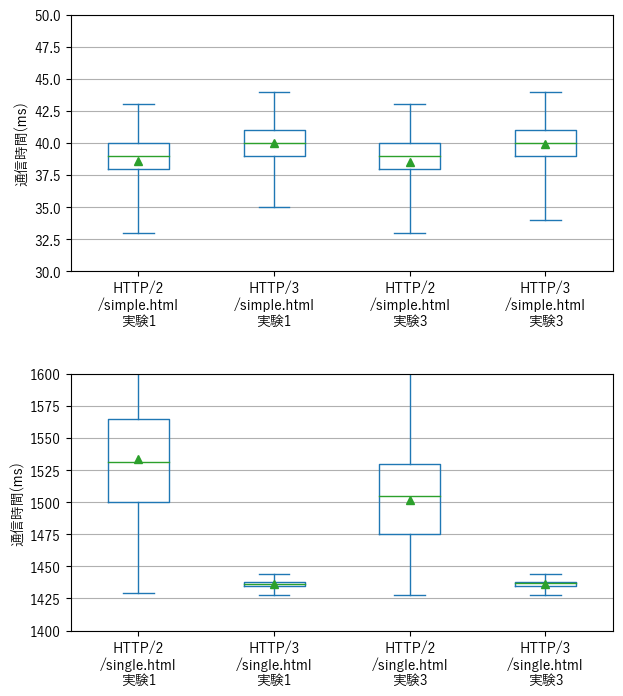

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

ploted = results[
    [
        "../log-simple-client1-h2",
        "../log-simple-client1-h3",
        "../log-simple-reverse1-h2",
        "../log-simple-reverse1-h3",
    ]
].copy()
ploted.columns = [
    "HTTP/2\n/simple.html\n実験1",
    "HTTP/3\n/simple.html\n実験1",
    "HTTP/2\n/simple.html\n実験3",
    "HTTP/3\n/simple.html\n実験3",
]
ploted = ploted.plot.box(ax=axes[0], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100])
ploted.grid(which="major", axis="y")
# ploted.set_yticks([0, 50, 100, 150])
ploted.set_ylim(30, 50)

ploted = results[
    [
        "../log-single-client1-h2",
        "../log-single-client1-h3",
        "../log-single-reverse1-h2",
        "../log-single-reverse1-h3",
    ]
].copy()
ploted.columns = [
    "HTTP/2\n/single.html\n実験1",
    "HTTP/3\n/single.html\n実験1",
    "HTTP/2\n/single.html\n実験3",
    "HTTP/3\n/single.html\n実験3",
]
ploted = ploted.plot.box(ax=axes[1], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100])
ploted.grid(which="major", axis="y")
# ploted.set_yticks([1400, 1500, 1600])
ploted.set_ylim(1400, 1600)


In [12]:
from scipy.stats import f
from scipy import stats
import numpy as np


def ftest(a, b):
    # 　統計量Fの計算
    v1 = np.var(a, ddof=1)
    v2 = np.var(b, ddof=1)
    n1 = len(a)
    n2 = len(b)
    f_value = v1 / v2

    # 帰無仮説が正しい場合にFが従う確率分を生成
    f_frozen = f.freeze(dfn=n1 - 1, dfd=n2 - 1)

    # 右側
    p1 = f_frozen.sf(f_value)
    # 左側
    p2 = f_frozen.cdf(f_value)
    # 小さい方の2倍がp値
    p_value = min(p1, p2) * 2

    # 統計量Fとp値を返す
    return f_value, p_value


def t_test(a, b):
    a = a.dropna()
    b = b.dropna()
    print(
        a.mean(),
        a.std(),
        b.mean(),
        b.std(),
    )
    f = ftest(
        a,
        b,
    )
    toubunsanse = (
        ftest(
            a,
            b,
        )[1]
        > 0.0005
    )
    print(f"{f=}")
    print(f"{toubunsanse=}")
    print(
        stats.shapiro(a)[1],
        stats.shapiro(b)[1],
    )
    print(
        stats.ttest_ind(
            a,
            b,
            equal_var=toubunsanse,
        )
    )


38.47995991983968 1.8551074008809358 39.87927565392354 1.9359099435764828
f=(0.9182645425300449, 0.17882062589527375)
toubunsanse=True
1.0308752842591535e-27 1.3740729304166275e-24
Ttest_indResult(statistic=-16.471141932121892, pvalue=3.0481205677693724e-57)


<AxesSubplot: ylabel='Frequency'>

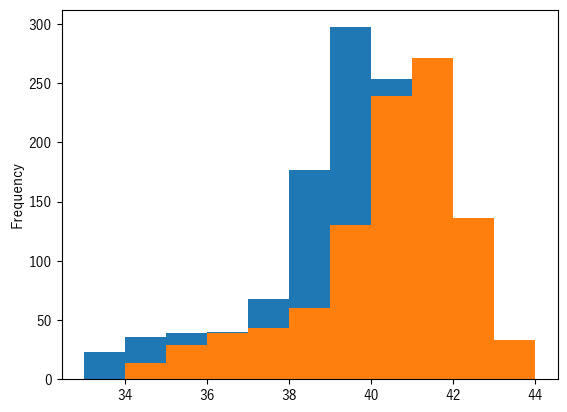

In [ ]:
t_test(results["../log-simple-reverse1-h2"], results["../log-simple-reverse1-h3"])
results["../log-simple-reverse1-h2"].plot.hist()
results["../log-simple-reverse1-h3"].plot.hist()

1501.7404809619238 38.367616639412304 1436.2137096774193 2.83745553864572
f=(182.84012685566816, 0.0)
toubunsanse=False
6.02226268853201e-09 1.0705937004973354e-12
Ttest_indResult(statistic=53.80562436398438, pvalue=1.3975542391637851e-298)


<AxesSubplot: ylabel='Frequency'>

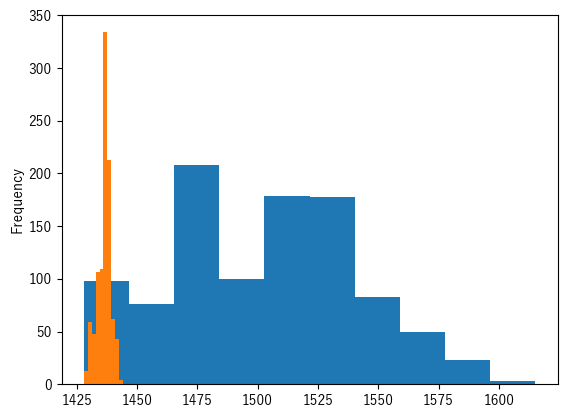

In [ ]:
t_test(results["../log-single-reverse1-h2"], results["../log-single-reverse1-h3"])
results["../log-single-reverse1-h2"].plot.hist()
results["../log-single-reverse1-h3"].plot.hist()